NEURAL MACHINE TRANSLATION WITH TRANSFORMER
Dịch các câu từ tiếng Anh sang tiếng Việt sử dụng mô hình Transformer

Ở các bài tập trước, chúng ta đã giải quyết bài toán dịch máy bằng cách sử dụng mô hình Sequence-to-Sequence (Seq2Seq) cùng với cơ chế Attention. Nếu như mô hình Seq2Seq cho khả năng dịch thuật còn hạn chế, thì cơ chế Attention đã cải thiện phần nào hiệu năng thông qua việc tập trung sự chú ý vào các vùng chứa thông tin quan trọng trong câu. Tuy nhiên, chúng ta mới chỉ thực nghiệm cơ chế Attention bằng cách gắn thêm một/một số lượng Attention Head vào mô hình để gán trọng số cho các đặc trưng được trích xuất từ các lớp trước đó thông qua mạng RNN. Vậy, liệu chúng ta có thể thay thế tất cả các lớp CNN/RNN trước đó thành các lớp kiến trúc Attention hay không? Và nếu làm như vậy thì có giúp mô hình dịch máy học tốt hơn hay không?

Câu trả lời đã được công bố trong công trình ["Attention is All you Need"](https://proceedings.neurips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) của Ashish Vaswani và cộng sự, năm 2017, giới thiệu về kiến trúc Transformer.
Transformer là một kiến trúc mạng học sâu mà ở đó các lớp CNN hay RNN được thay thế bằng các mô-đun self-attention. Cơ chế self-attention cho phép mô hình Transformer truyền tải thông tin một cách dễ dàng qua các chuỗi đầu vào. Hình 1 dưới đây thể hiện sự khác biệt về kiến trúc mô hình giữa RNN+Attention và Transformer.

Lưu ý: Nên thay đổi runtime sang GPU runtime để quá trình huấn luyện có thể nhanh hơn.

<table>
<tr>
  <th> Mô hình <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention</a></th>
  <th>Một lớp Transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

In [1]:
# @title Khởi tạo các hàm và lớp cần thiết dựa trên các code trước đây
# import from custom utils.py
# from utils import data_preprocessing, Translator, evaluate


from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from keras.models import load_model, Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import random

from sklearn.model_selection import train_test_split

def masked_loss(label, pred):
    mask = tf.argmax(label, axis=-1) != 0
    loss_object = tf.keras.losses.CategoricalCrossentropy(
        from_logits=False, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.argmax(label, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def fix_random_seed(seed_value = 42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

def data_preprocessing(lines):
    eng_train_lines = list()
    vie_train_lines = list()

    eng_val_lines = list()
    vie_val_lines = list()

    eng_full_lines = list()
    vie_full_lines = list()

    train_data, val_data = train_test_split(lines, test_size=0.1)


    eng_train_lines = list(train_data.eng)
    vie_train_lines = [ '<START> ' + line_vie + ' <END>'  for line_vie in train_data.vie]

    eng_val_lines = list(val_data.eng)
    vie_val_lines = [ '<START> ' + line_vie + ' <END>'  for line_vie in val_data.vie]

    eng_full_lines = eng_train_lines + eng_val_lines
    vie_full_lines = vie_train_lines + vie_val_lines

    eng_tokenizer = preprocessing.text.Tokenizer()
    eng_tokenizer.fit_on_texts( eng_full_lines )

    tokenized_full_eng_lines = eng_tokenizer.texts_to_sequences( eng_full_lines )
    tokenized_train_eng_lines = eng_tokenizer.texts_to_sequences( eng_train_lines )
    tokenized_val_eng_lines = eng_tokenizer.texts_to_sequences( eng_val_lines )
    max_input_length = np.array( [len( token_seq ) for token_seq in tokenized_full_eng_lines] ).max()

    vie_tokenizer = preprocessing.text.Tokenizer()
    vie_tokenizer.fit_on_texts( vie_full_lines )
    tokenized_full_vie_lines = vie_tokenizer.texts_to_sequences( vie_full_lines )
    tokenized_train_vie_lines = vie_tokenizer.texts_to_sequences( vie_train_lines )
    tokenized_val_vie_lines = vie_tokenizer.texts_to_sequences( vie_val_lines )
    max_output_length = np.array( [len( token_seq ) for token_seq in tokenized_full_vie_lines] ).max()

    padded_train_eng_lines = preprocessing.sequence.pad_sequences( tokenized_train_eng_lines, maxlen=max(max_input_length, max_output_length), padding='post' )
    encoder_train_input_data = np.array( padded_train_eng_lines )

    padded_val_eng_lines = preprocessing.sequence.pad_sequences( tokenized_val_eng_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    encoder_val_input_data = np.array( padded_val_eng_lines )

    eng_word_dict = eng_tokenizer.word_index
    num_eng_tokens = len( eng_word_dict )+1

    print( 'Độ dài lớn nhất của English là {}'.format( max_input_length ))
    print( 'Kích thước dữ liệu của Encoder  -> {}'.format( encoder_train_input_data.shape ))
    print( 'Số lượng English tokens = {}'.format( num_eng_tokens))



    # sử dụng pad_sequences để cố định kích thước output của decoder
    padded_train_vie_lines = preprocessing.sequence.pad_sequences( tokenized_train_vie_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    decoder_train_input_data = np.array( padded_train_vie_lines )

    padded_val_vie_lines = preprocessing.sequence.pad_sequences( tokenized_val_vie_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    decoder_val_input_data = np.array( padded_val_vie_lines )

    vie_word_dict = vie_tokenizer.word_index
    num_vie_tokens = len( vie_word_dict )+1


    print( 'Độ dài lớn nhất của tiếng việt là {}'.format( max_output_length ))
    print( 'kích thước dữ liệu đầu vào của Decoder -> {}'.format( decoder_train_input_data.shape ))
    print( 'Số lượng Vietnamese tokens = {}'.format( num_vie_tokens))



    input_decoder_target_data = list()

    # TODO: chúng ta sẽ loại bỏ '<START> ' đầu tiên của các dòng trong biến `tokenized_vie_lines`
    # và thêm vào `input_decoder_target_data`


    for token_seq in tokenized_train_vie_lines:
        input_decoder_target_data.append( token_seq[ 1 : ] )
        # input_decoder_target_data.append( token_seq[ 1 : ] )


    padded_vie_lines = preprocessing.sequence.pad_sequences(input_decoder_target_data, maxlen=max_output_length, padding='post')
    onehot_vie_lines = utils.to_categorical( padded_vie_lines , num_vie_tokens )
    decoder_target_data = np.array(onehot_vie_lines)
    print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape))

    map_vie_i2w = {val: key for key, val in vie_word_dict.items()}
    val_target = [[[map_vie_i2w[i] for i in line[1:-1]]] for line in tokenized_val_vie_lines]
    return (encoder_train_input_data, decoder_train_input_data, decoder_target_data), (encoder_val_input_data,  decoder_val_input_data, val_target), \
                    (eng_word_dict, vie_word_dict), (num_eng_tokens, num_vie_tokens), (eng_tokenizer, vie_tokenizer), (max_input_length, max_output_length)

def positional_encoding(length, depth):
    depth = depth/2
    # TODO: `angle` sẽ được tính thông qua công thức trên
    # với các input là `depth` và `length`


    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    angle = 1 / (10000**depths)         # (1, depth)
    angle = positions * angle      # (pos, depth)


    pos_encoding = np.concatenate(
        [np.sin(angle), np.cos(angle)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    # TODO: định nghĩa lớp `BaseAttention` với input
    # là các siêu tham số của 'tf.keras.layers.MultiHeadAttention'

    self.mha  = None # MultiHeadAttention
    self.layernorm = None
    self.add = None

    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()


    # TODO: định nghĩa lớp `FeedForward`
    # với input là dff, d_model lần lượt là kích thước output của
    # lớp 'Dense' thứ nhất và thứ hai, sau lớp `Dense` đầu tiên là
    # activation RELU, sau lớp thứ 2 có 1 lớp `Dropout`.
    # Sau hai lớp `Dense` là lớp `Add` và `LayerNormalization`.

    self.seq = None # nên `tf.keras.Sequential` để chứa 2 lớp `Dense`
    self.add = None
    self.layer_norm = None
    ### BEGIN SOLUTION
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()
    ### END SOLUTION

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
  def compute_output_shape(self, input_shape):
    return [None, None, self.d_model]

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

    return x

class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

class Translator:

    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None, loss = masked_loss):
        fix_random_seed()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation=tf.keras.activations.softmax)

        self.eng_tokenizer = tokenizers[0]
        self.vie_tokenizer = tokenizers[1]

        self.d_model = d_model
        self.map_vie_i2w = {val: key for key, val in vie_word_dict.items()}
        self.vie_word_dict = vie_word_dict
        self.loss = loss


    def build(self):
        encoder_inputs = tf.keras.layers.Input(shape=( None,))
        decoder_inputs = tf.keras.layers.Input(shape=( None,))

        context = self.encoder(encoder_inputs)  # (batch_size, context_len, d_model)

        output = self.decoder(decoder_inputs, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        output = self.final_layer(output)  # (batch_size, target_len, target_vocab_size)

        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy.
            del output._keras_mask
        except AttributeError:
            pass

        self.model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )


    # Load mô hình từ file
    def load(self, model_file):
        self.model = load_model(model_file)

    # Lưu mô hình hiện tại xuống file
    def save(self, model_file):
        self.model.save(model_file)

    # Tóm tắt kiến trúc mạng
    def summary(self):
        self.model.summary()

    # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
    def predict(self, x_test):
        return self.model.predict(x_test)

    def train(self, encoder_input_data , decoder_input_data, decoder_target_data):
        # Các hyper-parameter ở đây được chỉnh để có thể so sánh với mô hình trước.
        # Nếu muốn, các bạn có thể tinh chỉnh để đạt hiệu suất cao hơn.
        learning_rate = CustomSchedule(self.d_model)
        # print(learning_rate)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                        epsilon=1e-9)
        self.model.compile(
                loss=self.loss,
                optimizer=optimizer,
                metrics=[masked_accuracy],
                )
        self.model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=8, epochs=12)

    def translate(self, input, return_attention=False):
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        input = tf.convert_to_tensor(input, dtype=tf.int64)

        start, end = self.vie_word_dict['start'], self.vie_word_dict['end']
        output_array = output_array.write(0, [start])

        for i in tf.range(max_output_length):
            output = tf.transpose(output_array.stack())
            predictions = self.model([input, output], training=False)

            # Select the last token from the `seq_len` dimension.

            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            if predicted_id[0] == end or predicted_id[0]==0:
                break

            output_array = output_array.write(i+1, predicted_id[0])
        output = tf.transpose(output_array.stack())
        # print(output)
        text = [self.map_vie_i2w.get(i, '') for i in output[0].numpy()[1:]]  # Shape: `()`.
        if return_attention:
            self.model([input, output], training=False)
            attention_weights = self.decoder.last_attn_scores
            attention_heads = tf.squeeze(attention_weights, 0)
            return text, attention_heads
        return text

    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)

        input = self.eng_tokenizer.texts_to_sequences([text])
        input = preprocessing.sequence.pad_sequences(input, maxlen=max_input_length , padding='post' )
        output, attention = self.translate(input, return_attention=True)
        attention_weights = tf.concat(attention, 0)
        context = text.split()

        for i in range(len(attention_weights)):
            attention = attention_weights[i][:, :len(context)]
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(1, 1, 1)

            ax.matshow(attention, cmap='viridis', vmin=0.0)

            fontdict = {'fontsize': 14}

            ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
            ax.set_yticklabels([''] + output, fontdict=fontdict)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

            ax.set_ylabel('Output text')
            ax.set_xlabel(f'Head {i}')



class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def evaluate(model, encoder_val_input_data, val_target, num_sample=None):
    num_sample = encoder_val_input_data.shape[0] if num_sample==None else num_sample

    predict_translation = []
    eng_sentence = []

    for i in tqdm(range( num_sample ) ):
        decoded_translation = model.translate(encoder_val_input_data[ i ][None,...])
        eng_sentence.append(encoder_val_input_data[ i ])
        predict_translation.append( decoded_translation )


    predict = [f for f in predict_translation]

    references = val_target[:num_sample]
    candidates = predict
    score = corpus_bleu(references, candidates, weights=(0.5, 0.5))
    print('\nGiá trị bleu score là', score)

2025-04-11 00:55:45.190975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744332945.392283      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744332945.450692      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# import các thư viện cần thiết
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import load_model, Model
from keras import layers , activations , models , preprocessing , utils
from tensorflow.keras import layers, activations, models, preprocessing, utils
fix_random_seed()

In [3]:
lines = None
lines = pd.read_table('./data/vie.txt' , names=['eng' , 'vie' , 'c' ] )
lines = lines.drop(['c'] , axis=1 )[0:5000]
lines.tail()

,eng,vie
4995,Who's your favorite movie star?,Ngôi sao điện ảnh mà bạn yêu thích là ai thế?
4996,Who's your favorite movie star?,Ngôi sao điện ảnh mà bạn yêu thích là ai vậy?
4997,Why aren't you in your uniform?,Tại sao bạn không mặc đồng phục?
4998,Will he be coming this evening?,Tối nay anh ấy có đến không?
4999,Will he be coming this evening?,Tối nay ông ấy có đến không?


In [4]:
# from utils import data_preprocessing
train_data, val_data, word_dict, num_tokens, tokenizers, max_length = data_preprocessing(lines)

(encoder_train_input_data, decoder_train_input_data, decoder_target_data) = train_data
(encoder_val_input_data,  decoder_val_input_data, val_target) = val_data
(eng_word_dict, vie_word_dict), (num_eng_tokens, num_vie_tokens) = word_dict, num_tokens
(eng_tokenizer, vie_tokenizer), (max_input_length, max_output_length) = tokenizers, max_length


Độ dài lớn nhất của English là 9
Kích thước dữ liệu của Encoder  -> (4500, 17)
Số lượng English tokens = 2451
Độ dài lớn nhất của tiếng việt là 17
kích thước dữ liệu đầu vào của Decoder -> (4500, 17)
Số lượng Vietnamese tokens = 1861
Decoder target data shape -> (4500, 17, 1861)


In [5]:
num_layers = 2
d_model = 64
dff = 128
num_heads = 2
dropout_rate = 0.1

## Khởi tạo và huấn luyện mô hình với cài đặt mặc định

In [6]:
alpha=Translator(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict, tokenizers=tokenizers)

alpha.build()

alpha.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(alpha, encoder_val_input_data, val_target)

I0000 00:00:1744332959.189414      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passe

Epoch 1/12


I0000 00:00:1744332984.465885      88 service.cc:148] XLA service 0x7ce02800d6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744332984.466470      88 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744332986.370313      88 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.5773 - masked_accuracy: 3.4348e-04   

I0000 00:00:1744332995.011981      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 7.0444 - masked_accuracy: 0.0774
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.0815 - masked_accuracy: 0.2100
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.3011 - masked_accuracy: 0.3039
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.7245 - masked_accuracy: 0.3765
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2703 - masked_accuracy: 0.4279
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9025 - masked_accuracy: 0.4771
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6382 - masked_accuracy: 0.5045
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4101 - masked_accuracy: 0.5338
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1217 - masked_accuracy: 0.5731
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.8933 - masked_accuracy: 0.6074
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7139 - masked_a

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


Giá trị bleu score là 0.3868717220183509


## Thay Đổi Feedforward Network (FFN) trong Transformer


Trong mô hình Transformer, một trong những thành phần quan trọng là FeedForward (FFN). Khối này bao gồm hai lớp Dense và một hàm kích hoạt (thường là ReLU) giữa chúng, cùng với một skip connection để cải thiện khả năng học của mô hình. Vậy nếu chúng ta thay đổi cấu trúc của FFN, cụ thể là loại bỏ hàm kích hoạt ReLU hoặc loại bỏ skip connection thì điều gì sẽ xảy ra?

Trong phần thực nghiệm này, chúng ta sẽ tiến hành các thay đổi sau đối với FFN:
  - Loại bỏ ReLU:
  - Loại bỏ Skip Connection:

### Loại bỏ ReLU
Thông thường, khối FFN trong Transformer sử dụng hàm kích hoạt ReLU giữa hai lớp Dense. ReLU giúp mô hình học được các đặc trưng phi tuyến tính và cải thiện hiệu suất của mô hình. Tuy nhiên, nếu chúng ta loại bỏ ReLU, khối FFN sẽ trở thành một khối tuyến tính thuần túy. Điều này có thể làm giảm khả năng học các đặc trưng phức tạp của mô hình, và chúng ta sẽ kiểm tra xem hiệu suất của mô hình thay đổi như thế nào.

In [7]:
class DFeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.dff = dff
        self.d_model = d_model

        # TODO: định nghĩa hàm `__init__` sao cho hai lớp Fully Connected sử dụng các hàm kích hoạt tuyến tính
        #
        # Lưu ý: Vẫn giữ drop-out như kiến trúc cũ

        ### BEGIN SOLUTION
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        ### END SOLUTION
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [8]:
class DEncoderLayer(EncoderLayer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.ffn = DFeedForward(d_model, dff)


class DEncoder(Encoder):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    self.enc_layers = [
        DEncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

class DDecoderLayer(DecoderLayer):
  def __init__(self,
               **kwargs):
    super().__init__(**kwargs)
    self.ffn = DFeedForward(d_model, dff)



class DDecoder(Decoder):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    self.dec_layers = [
        DDecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]


class Delta(Translator):
    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None):
        super().__init__(num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate, vie_word_dict, tokenizers)
        self.encoder = DEncoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = DDecoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)


delta=Delta(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict,
    tokenizers=tokenizers)


delta.build()

delta.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(delta, encoder_val_input_data, val_target)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_11' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'd_feed_forward' (of type DFeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.war

Epoch 1/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - loss: 7.0272 - masked_accuracy: 0.0779
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.0942 - masked_accuracy: 0.2060
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.3220 - masked_accuracy: 0.2971
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.8014 - masked_accuracy: 0.3636
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4181 - masked_accuracy: 0.4097
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.1211 - masked_accuracy: 0.4433
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9208 - masked_accuracy: 0.4635
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7754 - masked_accuracy: 0.4828
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5558 - masked_accuracy: 0.5063
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3616 - masked_accuracy: 0.5362
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2127

100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Giá trị bleu score là 0.2959953839324422


In [9]:
### BEGIN PUBLIC TESTS
x = tf.random.uniform((1, 10, 64))

custom_ffn = DFeedForward(64,128)
ffn = FeedForward(64,128)

out_ffn = ffn(x)
out_custom_ffn = custom_ffn(x)

assert not tf.reduce_all(tf.equal(out_ffn, out_custom_ffn))
### END PUBLIC TESTS

In [10]:
options = {0: 'hiệu suất beta xấp xỉ alpha (không chêch lệch quá 1%)',
           1: 'hiệu suất beta thấp hơn alpha k% (1<k<5)',
           2: 'hiệu suất beta thấp hơn alpha k% (5<=k<10)',
           3: 'hiệu suất beta thấp hơn alpha k% (10<=k<20)',
           4: 'hiệu suất beta thấp hơn alpha trên 20%',
           5: 'beta gần như không học gì (hiệu suất thấp hơn 10%)'}
your_choice = None
### BEGIN SOLUTION
your_choice = 2
### END SOLUTION
print("Theo mình thì: ", options[your_choice])

Theo mình thì:  hiệu suất beta xấp xỉ alpha (không chêch lệch quá 1%)


### Loại bỏ Skip connection trong FFN
Skip connection là một thành phần quan trọng trong Transformer, giúp truyền thông tin từ đầu vào trực tiếp đến đầu ra của khối FFN mà không qua các lớp trung gian. Điều này giúp giảm thiểu vấn đề gradient vanishing và giúp mô hình học nhanh hơn và ổn định hơn. Khi loại bỏ skip connection, chúng ta sẽ buộc mô hình học mọi đặc trưng chỉ thông qua các lớp Dense.

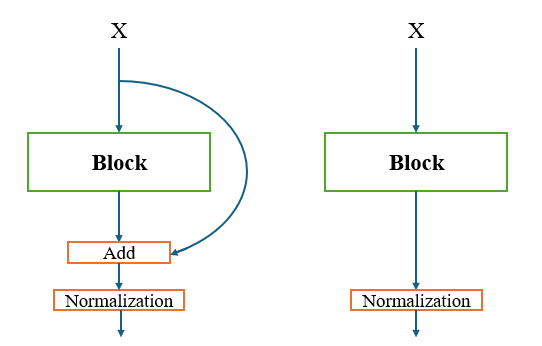

In [14]:
# TODO: định nghĩa lớp `EFeedForward` có kiến trúc tương tự như `FeedForward` trước đây nhưng không sử dụng skip-connection
# Lưu ý: Loại bỏ các khởi tạo không dùng đến
class EFeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        ### BEGIN SOLUTION
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.layer_norm = tf.keras.layers.LayerNormalization()
        ### END SOLUTION

    def call(self, x):
        ### BEGIN SOLUTION
        x = self.layer_norm(self.seq(x))
        return x
        ### END SOLUTION

In [ ]:
class EEncoderLayer(EncoderLayer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.ffn = EFeedForward(d_model, dff)


class EEncoder(Encoder):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    self.enc_layers = [
        EEncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

class EDecoderLayer(DecoderLayer):
  def __init__(self,
               **kwargs):
    super().__init__(**kwargs)
    self.ffn = EFeedForward(d_model, dff)



class EDecoder(Decoder):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    self.dec_layers = [
        EDecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]


class Epsilon(Translator):
    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None):
        super().__init__(num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate, vie_word_dict, tokenizers)
        self.encoder = EEncoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = EDecoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

epsilon=Epsilon(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict,
    tokenizers=tokenizers)


epsilon.build()

epsilon.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(epsilon, encoder_val_input_data, val_target)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'global_self_attention_18' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_45' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'e_feed_forward_4' (of type EFeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.

Epoch 1/12


In [ ]:
### BEGIN HIDDEN TESTS
try:
    import warnings
    warnings.filterwarnings('ignore')
    x = tf.random.uniform((1, 10, 64))

    custom_ffn = EFeedForward(64,128)
    ffn = FeedForward(64,128)

    out_ffn = ffn(x)
    out_custom_ffn = custom_ffn(x)

    assert not tf.reduce_all(tf.equal(out_ffn, out_custom_ffn))
### END PUBLIC TESTS

In [ ]:
options = {0: 'hiệu suất beta xấp xỉ alpha (không chêch lệch quá 1%)',
           1: 'hiệu suất beta thấp hơn alpha k% (1<k<5)',
           2: 'hiệu suất beta thấp hơn alpha k% (5<=k<10)',
           3: 'hiệu suất beta thấp hơn alpha k% (10<=k<20)',
           4: 'hiệu suất beta thấp hơn alpha trên 20%',
           5: 'beta gần như không học gì (hiệu suất thấp hơn 10%)'}
your_choice = None
### BEGIN SOLUTION
your_choice = 3
### END SOLUTION
print("Theo mình thì: ", options[your_choice])